In [1]:
import csv
import matplotlib.pyplot as plt

import xarray as xr

import pandas as pd
import json

import numpy as np
import seaborn as sns

# Reading classification csv file from zooniverse

In [2]:
classfile_in = '../zooniverse_raw/sugar-flower-fish-or-gravel-classifications_18_11_02.csv'
subject_in = '../zooniverse_raw/sugar-flower-fish-or-gravel-subjects_18_11_05.csv'

In [3]:
### Functions from https://github.com/zooniverse/Data-digging/blob/master/example_scripts/astronomy_rewind/workflow1to2.py

def JSONParser(data):
    """call json.loads"""
    return json.loads(data)


def load_classifications(filename, json_columns=None):
    """
    Load classifications into pandas dataframe.
    Some columns of the csv are embedded json and need special parsing.
    """
    json_columns = json_columns or ['metadata', 'annotations', 'subject_data']
    converters = {i: JSONParser for i in json_columns}

    return pd.read_csv(filename, converters=converters)

def unpack(series):
    """
    Return the first value in a series.
    All annotations values are lists because of a few multiple tasks.
    The second multiple task always has the value of 'None of the above'
    (For this dataset!)
    """
    return [a[0] for a in series]


def parse_classifications(filename,**kwarg):
    """
    Load classifications and datamunge annotations column.
    """
    data = load_classifications(filename,**kwarg)

    # Only need the first item in the annotations list of json objects
    data['annotations'] = unpack(data['annotations'])
    return data

In [4]:
def get_time_spent(obj):
    from datetime import timedelta, datetime
    time_fmt='%Y-%m-%dT%H:%M:%S.%fZ'
    start=datetime.strptime(obj[11]['started_at'],time_fmt)
    stop=datetime.strptime(obj[11]['finished_at'],time_fmt)
    d=stop-start
    if d.total_seconds() > 3600*10: d=0
    return d.total_seconds()

In [5]:
classification_data = parse_classifications(classfile_in,json_columns=['metadata', 'annotations', 'subject_data']); classification_data.tail()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
20206,129755508,magio,1830051.0,8c99af1e1ae0f6006a1f,8073,Full dataset,13.11,2018-11-02 15:15:23 UTC,NaN,NaN,"{'source': 'api', 'session': '2572c8d4566709b1...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27141271': {'retired': None, 'fn': '/project...",27141271
20207,129755509,magio,1830051.0,8c99af1e1ae0f6006a1f,8073,Full dataset,13.11,2018-11-02 15:15:23 UTC,NaN,NaN,"{'source': 'api', 'session': '2572c8d4566709b1...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27163085': {'retired': None, 'fn': '/project...",27163085
20208,129755510,magio,1830051.0,8c99af1e1ae0f6006a1f,8073,Full dataset,13.11,2018-11-02 15:15:23 UTC,NaN,NaN,"{'source': 'api', 'session': '2572c8d4566709b1...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27141021': {'retired': None, 'fn': '/project...",27141021
20209,129755525,lutz.hirsch,1837010.0,28e5711907d54bd94f66,8073,Full dataset,13.11,2018-11-02 15:15:30 UTC,NaN,NaN,"{'source': 'api', 'session': '655b7869b9f4cdbf...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27148023': {'retired': {'id': 24677542, 'wor...",27148023
20210,129755532,jkiliani,1837012.0,0487d4d9788931868f3a,8073,Full dataset,13.11,2018-11-02 15:15:34 UTC,NaN,NaN,"{'source': 'api', 'session': '7ba4639dcd776442...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27147809': {'retired': None, 'fn': '/project...",27147809


In [6]:
classification_data.annotations[0]

{'task': 'T0',
 'task_label': 'Draw bounding boxes around cloud regions',
 'value': [{'details': [],
   'frame': 0,
   'height': 371.2830505371094,
   'tool': 0,
   'tool_label': 'Sugar',
   'width': 389.17626953125,
   'x': 1025.257080078125,
   'y': 432.2316589355469}]}

In [7]:
classification_data.metadata[0]

{'finished_at': '2018-10-24T17:02:45.495Z',
 'interventions': {'message': False, 'opt_in': True},
 'live_project': False,
 'session': '88559898111399b0c5d554bebfa330e9829a65ebfb9485540a077ea3aecbb3cf',
 'source': 'api',
 'started_at': '2018-10-24T17:02:41.342Z',
 'subject_dimensions': [{'clientHeight': 313,
   'clientWidth': 469,
   'naturalHeight': 1400,
   'naturalWidth': 2100}],
 'user_agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36',
 'user_group_ids': [],
 'user_language': 'en',
 'utc_offset': '-7200',
 'viewport': {'height': 977, 'width': 960}}

In [8]:
# Get time spend on each classification
classification_data['time_spent'] = [get_time_spent(row) for row in classification_data.itertuples()]

# User statistics

In [9]:
def update_user_dict(user_dic,user_id, dic):
    # user existiert bereits
    if user_dic.get(user_id) != None:
        for key in dic.keys():
            if user_dic[user_id].get(key) != None:
                old_value = user_dic[user_id][key]
                new_value = old_value+dic[key]
                user_dic[user_id][key]=new_value
            else:
                user_dic[user_id][key]=dic[key]
    else:
        user_dic[user_id] = dic
    return user_dic

In [10]:
user_stat = {}
for u,user_classifications in classification_data.groupby('user_name'):
    pattern_types = user_classifications.annotations
    labels=np.array([])
    for classification in pattern_types:
        labels = np.append(labels,[value['tool'] for value in classification['value']])
    [nb_sugar, nb_flower, nb_fish, nb_gravel] = np.bincount(labels.astype(int),minlength=4)
    time_spent = user_classifications.time_spent.sum()
    user_stat = update_user_dict(user_stat, u, {'images_seen': len(user_classifications), 'fish': nb_fish,'gravel': nb_gravel, 'flower': nb_flower, 'sugar':nb_sugar, 'time_spent': time_spent})

In [11]:
DF_user = pd.DataFrame.from_dict(user_stat,orient='index')
DF_user['labels_done'] = DF_user.iloc[:,[1,2,3,4]].sum(axis=1)
DF_user.sort_values('labels_done',inplace=True)
DF_user.head()

,images_seen,fish,gravel,flower,sugar,time_spent,labels_done
not-logged-in-b454def8ef12f0860686,1,1,1,0,0,250.729,2
not-logged-in-6721fe35742a208c7ea5,5,0,0,1,2,142.907,3
friedhelmjansen,2,1,1,1,1,179.532,4
not-logged-in-169bca65941805c9a058,9,2,3,1,1,358.753,7
tobifinn,6,0,2,1,5,180.458,8


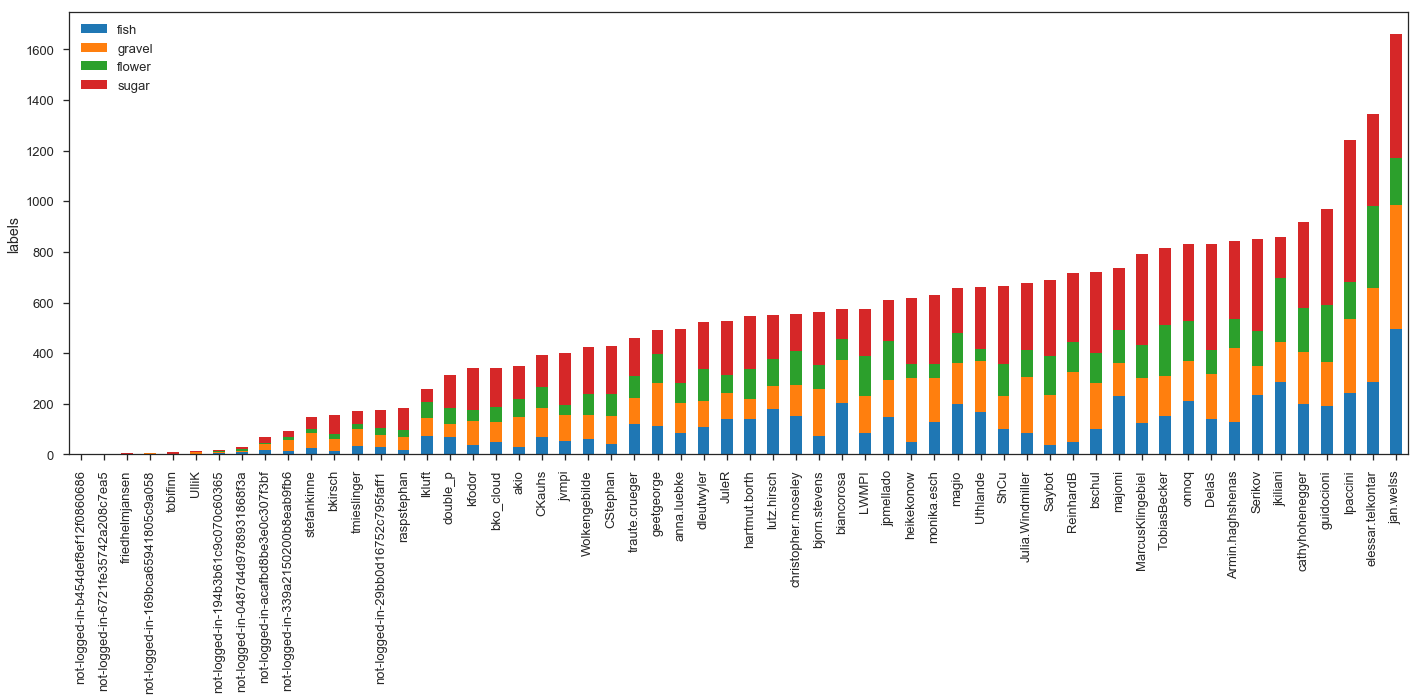

In [12]:
sns.set_context('talk')
sns.set_style('ticks')
p1=(DF_user.iloc[:,[1,2,3,4]]).plot(kind='bar', figsize=(20,10), stacked=True)
#DF_user.iloc[:,[0]].plot(kind='bar',ax=p1.axes, alpha=0.4)
p1.set_ylabel('labels')
#plt.hlines(500,-1,70)
plt.tight_layout()
plt.savefig('/Users/haukeschulz/Desktop/CloudClassificationDayStats_preliminary.png');

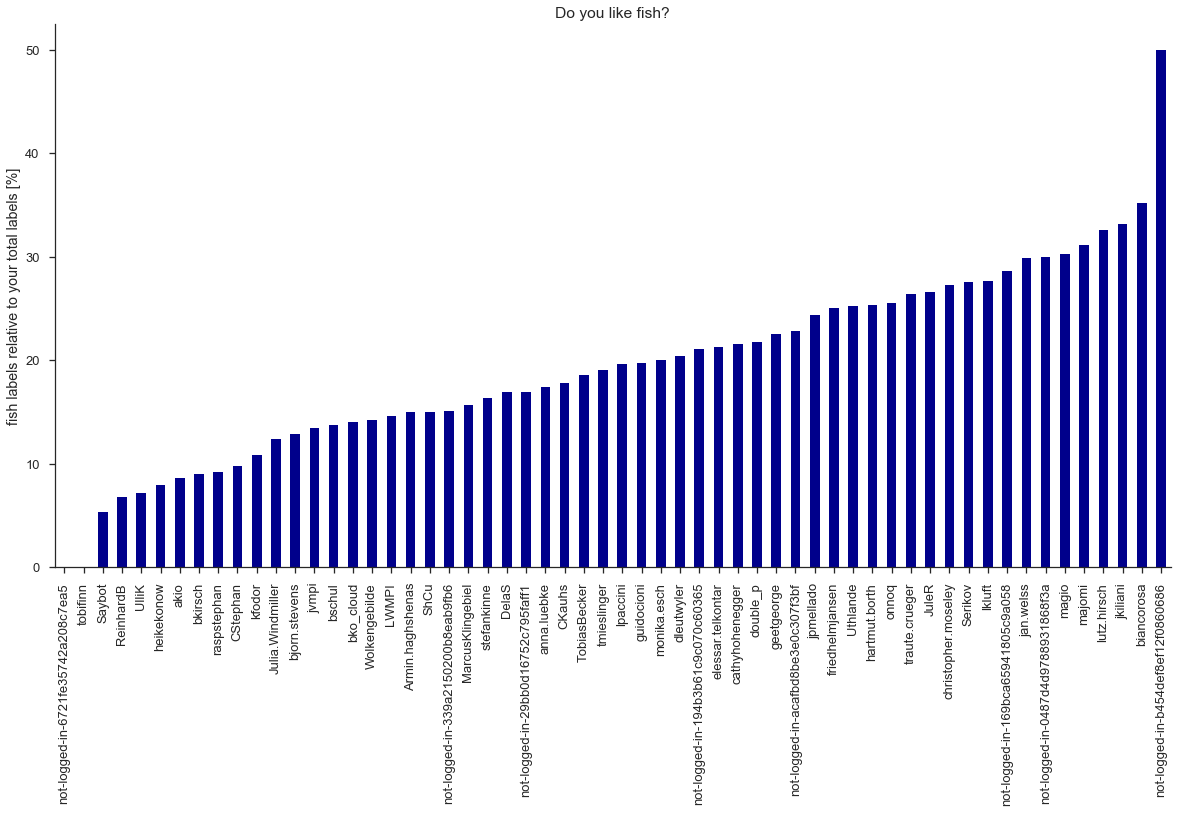

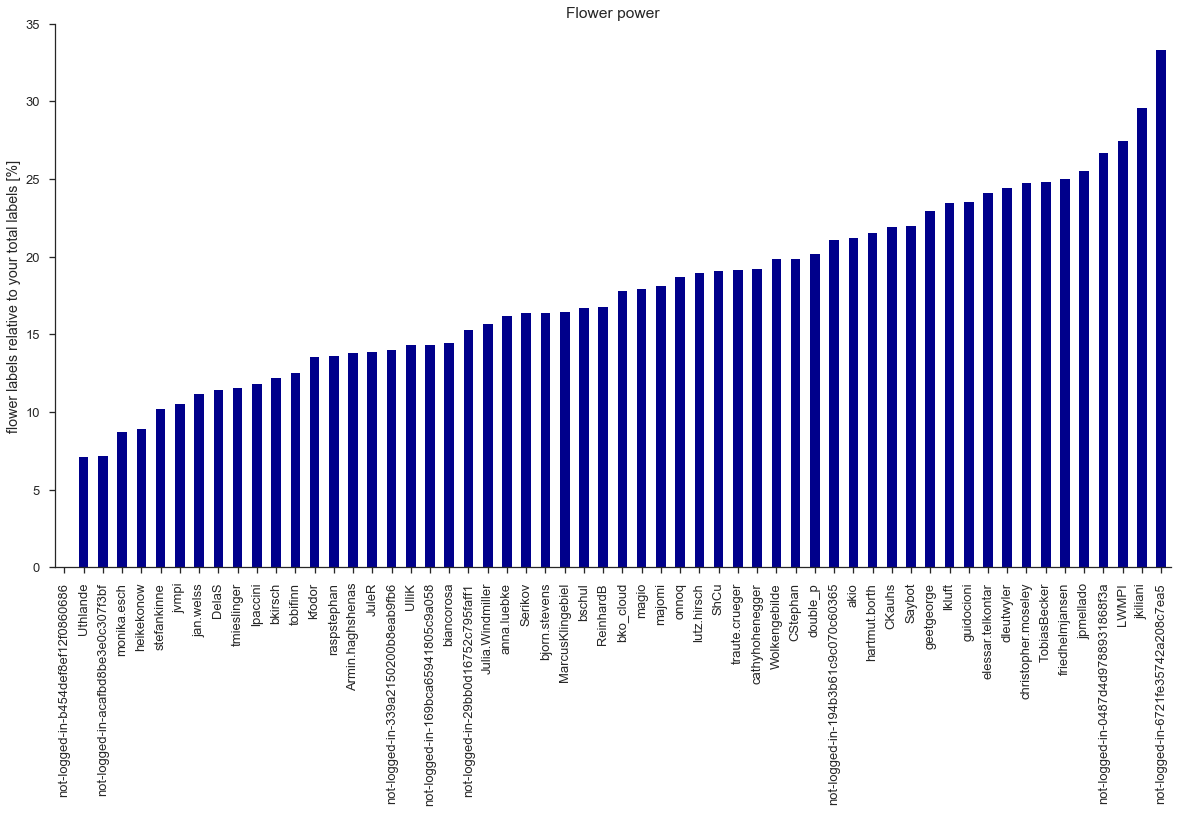

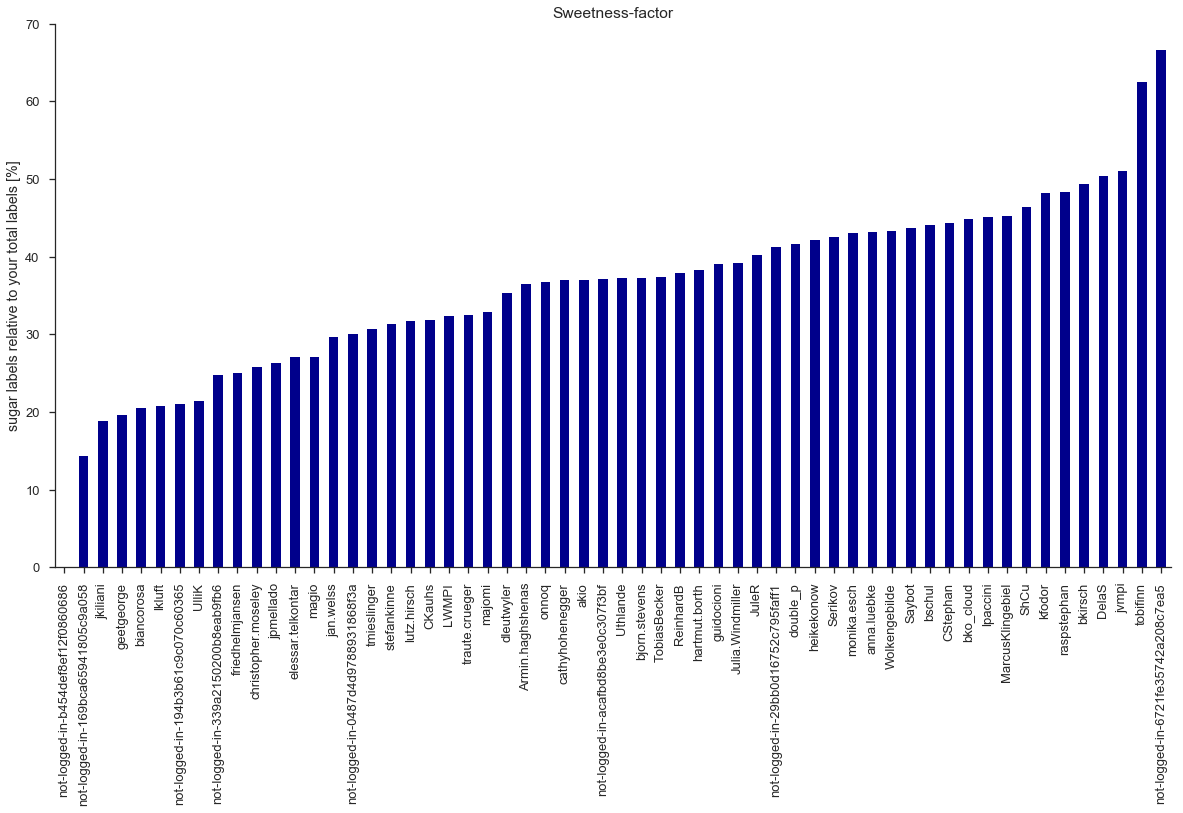

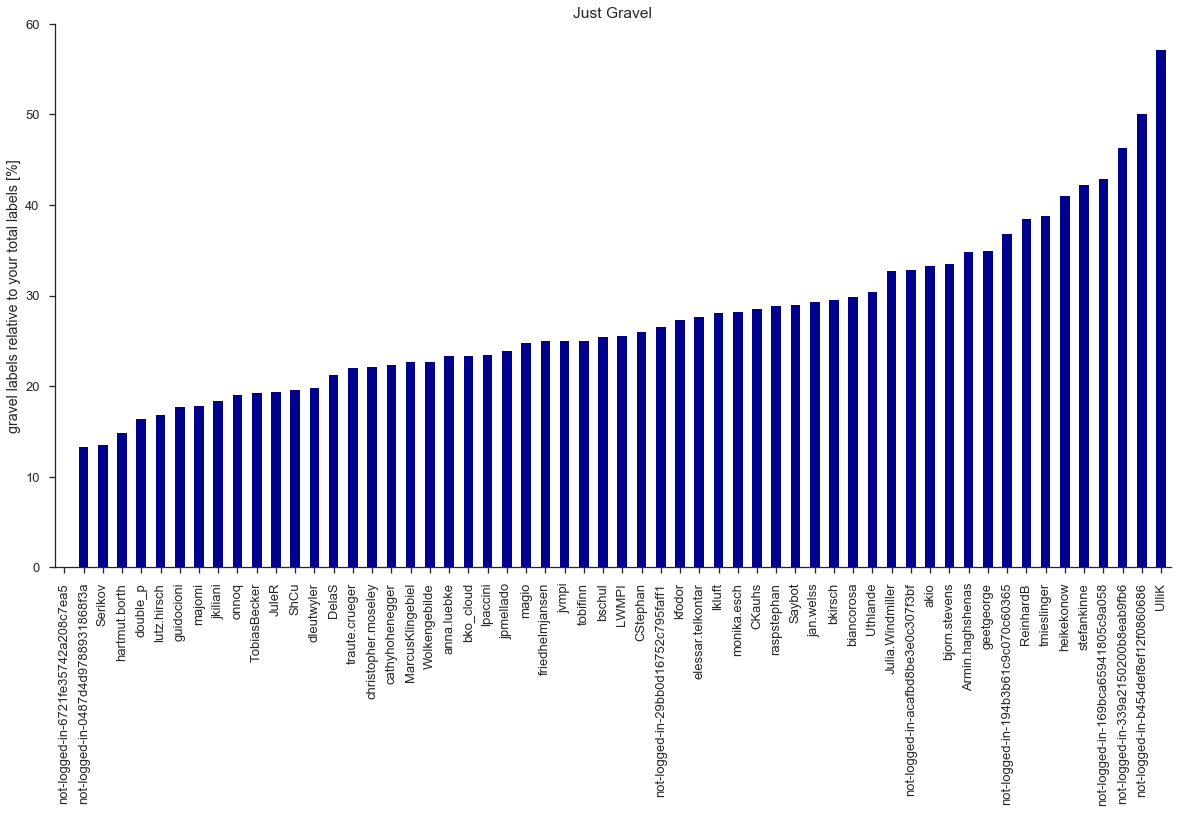

In [13]:
sns.set_context('talk')
sns.set_style('ticks')
titles=['Do you like fish?', 'Flower power', 'Sweetness-factor', 'Just Gravel']
for p,pattern in enumerate(['fish','flower','sugar','gravel']):
    plt.figure()
    pattern_percentage = pattern+'_percentage'
    DF_user[pattern_percentage] = DF_user[pattern]/DF_user.labels_done*100
    p1=DF_user.sort_values(pattern_percentage)[pattern_percentage].plot(kind='bar', figsize=(20,10), color='darkblue')
    t=p1.set_ylabel('{} labels relative to your total labels [%]'.format(pattern))
    #p1.set_title('Do you like {}?'.format(pattern))
    p1.set_title(titles[p])
    sns.despine()

# Time spent

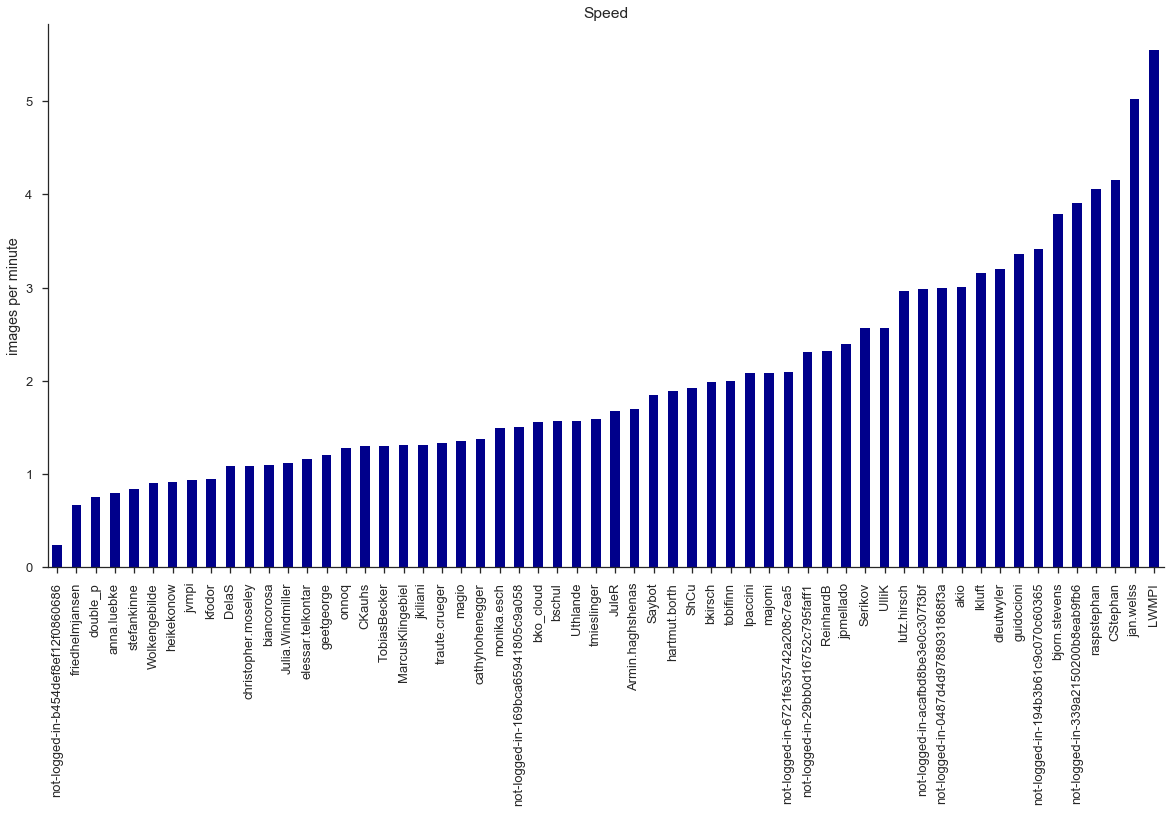

In [14]:
sns.set_context('talk')
sns.set_style('ticks')
DF_user['images_per_minute'] = 60/(DF_user.time_spent/DF_user.images_seen)
p1=DF_user.sort_values('images_per_minute').images_per_minute.plot(kind='bar', figsize=(20,10), stacked=True, color='darkblue')
#DF_user.iloc[:,[0]].plot(kind='bar',ax=p1.axes, alpha=0.4)
t=p1.set_ylabel('images per minute')
p1.set_title('Speed')
sns.despine()

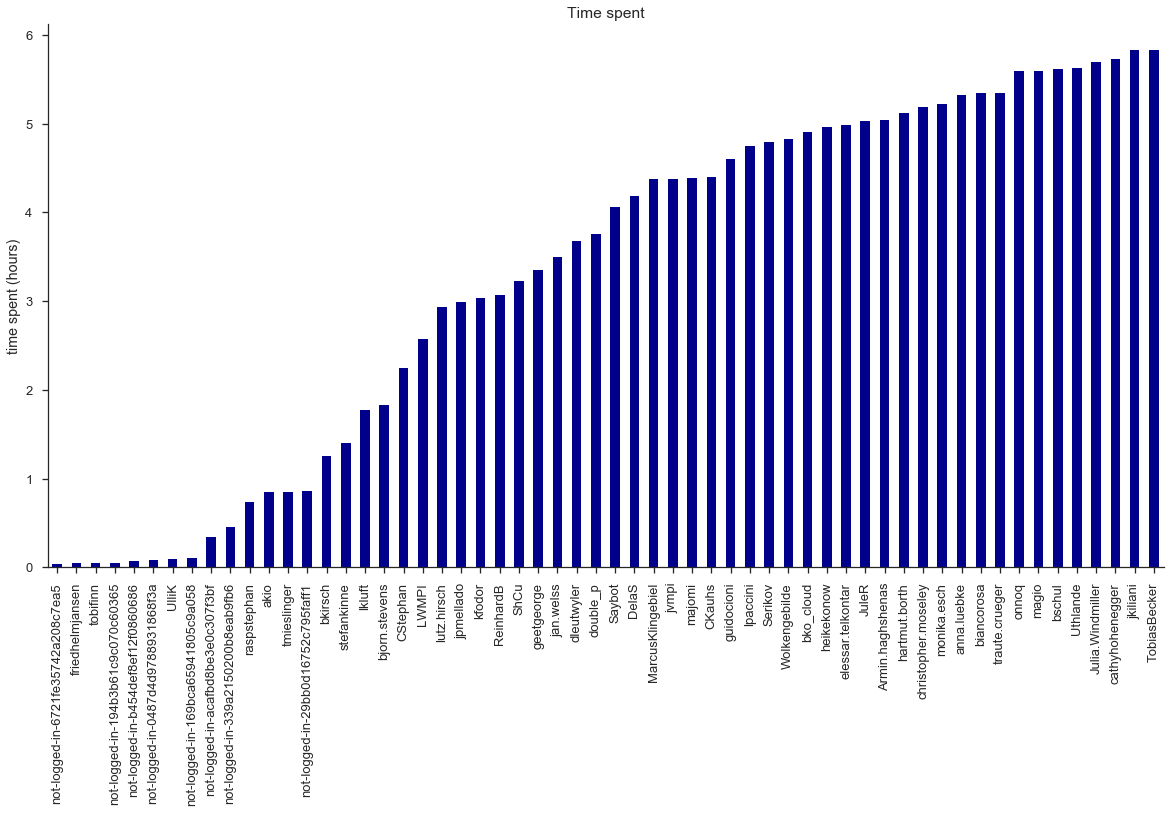

In [15]:
sns.set_context('talk')
sns.set_style('ticks')
p1=(DF_user.sort_values('time_spent').time_spent/3600).plot(kind='bar', figsize=(20,10), stacked=True, color='darkblue')
#DF_user.iloc[:,[0]].plot(kind='bar',ax=p1.axes, alpha=0.4)
t=p1.set_ylabel('time spent (hours)')
p1.set_title('Time spent')
sns.despine()

# Subject set statistics

In [16]:
subject_data = load_classifications(subject_in)
subject_data = subject_data.set_index('subject_id'); subject_data.head()

,project_id,workflow_id,subject_set_id,metadata,locations,classifications_count,retired_at,retirement_reason,created_at,updated_at
subject_id,,,,,,,,,,
26976345,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:28 UTC,2018-10-24 16:42:28 UTC
26976346,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:29 UTC,2018-10-24 16:42:29 UTC
26976347,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:31 UTC,2018-10-24 16:42:31 UTC
26976348,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:32 UTC,2018-10-24 16:42:32 UTC
26976349,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:33 UTC,2018-10-24 16:42:33 UTC


In [17]:
subjects_name = {60811:'BCO_DJF_Aqua',60812:'BCO_DJF_Terra',60813: 'BCO_MAM_Aqua',\
                 60814: 'BCO_MAM_Terra',60815:'R2_DJF_Aqua',60816:'R2_DJF_Terra',\
                 60817:'R3_DJF_Aqua', 60818:'R3_DJF_Terra',60819:'R3_SON_Aqua',\
                 60835: 'R3_SON_Terra'}
for s, subject_set in subject_data.groupby('subject_set_id'):
    try:
        print(subjects_name[s])
        print(len(subject_set),subject_set.classifications_count.sum(),\
              len(subject_set.classifications_count.nonzero()[0]),\
              np.round(len(subject_set.classifications_count.nonzero()[0])/len(subject_set)*100,1))
        print('maximum number of classifications per image: {}'.format(subject_set.classifications_count.max()))
    except KeyError:
        print('Subset {} not of interest'.format(s))

Subset 60713 not of interest
Subset 60720 not of interest
Subset 60721 not of interest
Subset 60722 not of interest
BCO_DJF_Aqua
993 1867 854 86.0
maximum number of classifications per image: 5
BCO_DJF_Terra
993 1898 856 86.2
maximum number of classifications per image: 5
BCO_MAM_Aqua
1012 1874 853 84.3
maximum number of classifications per image: 5
BCO_MAM_Terra
1012 1922 881 87.1
maximum number of classifications per image: 5
R2_DJF_Aqua
993 1867 858 86.4
maximum number of classifications per image: 5
R2_DJF_Terra
993 1970 871 87.7
maximum number of classifications per image: 5
R3_DJF_Aqua
993 1897 869 87.5
maximum number of classifications per image: 5
R3_DJF_Terra
993 1956 881 88.7
maximum number of classifications per image: 5
R3_SON_Aqua
1001 1891 869 86.8
maximum number of classifications per image: 4
Subset 60834 not of interest
R3_SON_Terra
1001 1929 881 88.0
maximum number of classifications per image: 5
Subset 60836 not of interest
Subset 60902 not of interest


# Distribution of pattern within region

In [18]:
def update_dict(region_dic,region_id, dic):
    # user existiert bereits
    if region_dic.get(region_id) != None:
        for key in dic.keys():
            if region_dic[region_id].get(key) != None:
                old_value = region_dic[region_id][key]
                new_value = old_value+dic[key]
                region_dic[region_id][key]=new_value
            else:
                region_dic[region_id][key]=dic[key]
    else:
        region_dic[region_id] = dic
    return region_dic

In [19]:
region_stat = {}
for e,entry in enumerate(classification_data.iterrows()):
    nb_fish = nb_gravel = nb_flower = nb_sugar = 0
    subject_id = entry[1].subject_ids
    workflow_c_id = entry[1].workflow_id
    pattern_types = entry[1].annotations
    labels = [value['tool'] for value in pattern_types['value']]
    [nb_sugar, nb_flower, nb_fish, nb_gravel] = np.bincount(labels,minlength=4)
    try:
        ind = np.where(subject_id == subject_data.index.values)[0][0]
        subset_id = subject_data.subject_set_id.values[ind]
        workflow_id = subject_data.workflow_id.values[ind]
        if workflow_c_id == np.float(8073):
            try:
                region_name = subjects_name[subset_id]
                region_stat = update_dict(region_stat, region_name, {'fish': nb_fish,'gravel': nb_gravel, 'flower': nb_flower, 'sugar':nb_sugar})
            except KeyError:
                continue
    except:
        continue

In [20]:
region_stat

{'BCO_DJF_Aqua': {'fish': 557, 'flower': 265, 'gravel': 1077, 'sugar': 897},
 'BCO_DJF_Terra': {'fish': 581, 'flower': 295, 'gravel': 951, 'sugar': 751},
 'BCO_MAM_Aqua': {'fish': 418, 'flower': 284, 'gravel': 630, 'sugar': 738},
 'BCO_MAM_Terra': {'fish': 462, 'flower': 488, 'gravel': 481, 'sugar': 688},
 'R2_DJF_Aqua': {'fish': 745, 'flower': 185, 'gravel': 785, 'sugar': 1314},
 'R2_DJF_Terra': {'fish': 721, 'flower': 298, 'gravel': 704, 'sugar': 1148},
 'R3_DJF_Aqua': {'fish': 400, 'flower': 502, 'gravel': 442, 'sugar': 1054},
 'R3_DJF_Terra': {'fish': 374, 'flower': 705, 'gravel': 315, 'sugar': 994},
 'R3_SON_Aqua': {'fish': 512, 'flower': 645, 'gravel': 363, 'sugar': 1030},
 'R3_SON_Terra': {'fish': 450, 'flower': 994, 'gravel': 292, 'sugar': 854}}

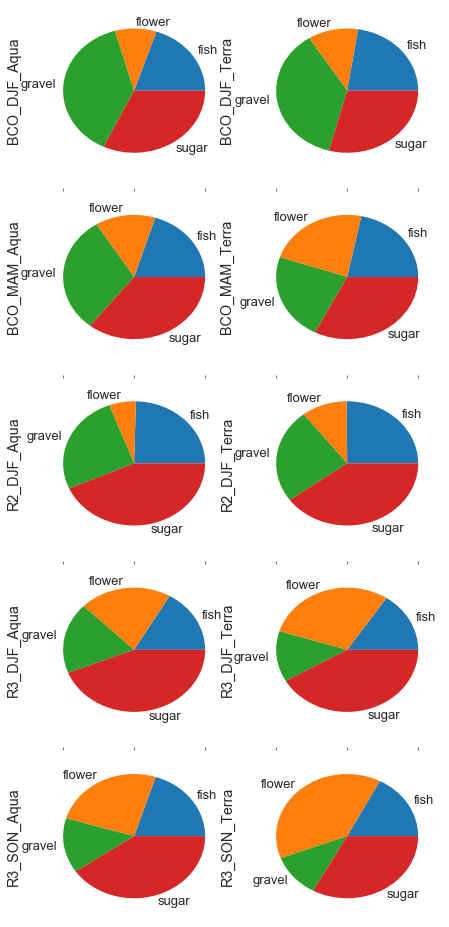

In [21]:
DF=pd.DataFrame.from_dict(region_stat,orient='columns')

DF.plot(kind='pie',figsize=(7,20),subplots=True,layout=(6, 2),legend=None)
sns.despine(offset=20)

In [22]:
# or just another layout of the same data

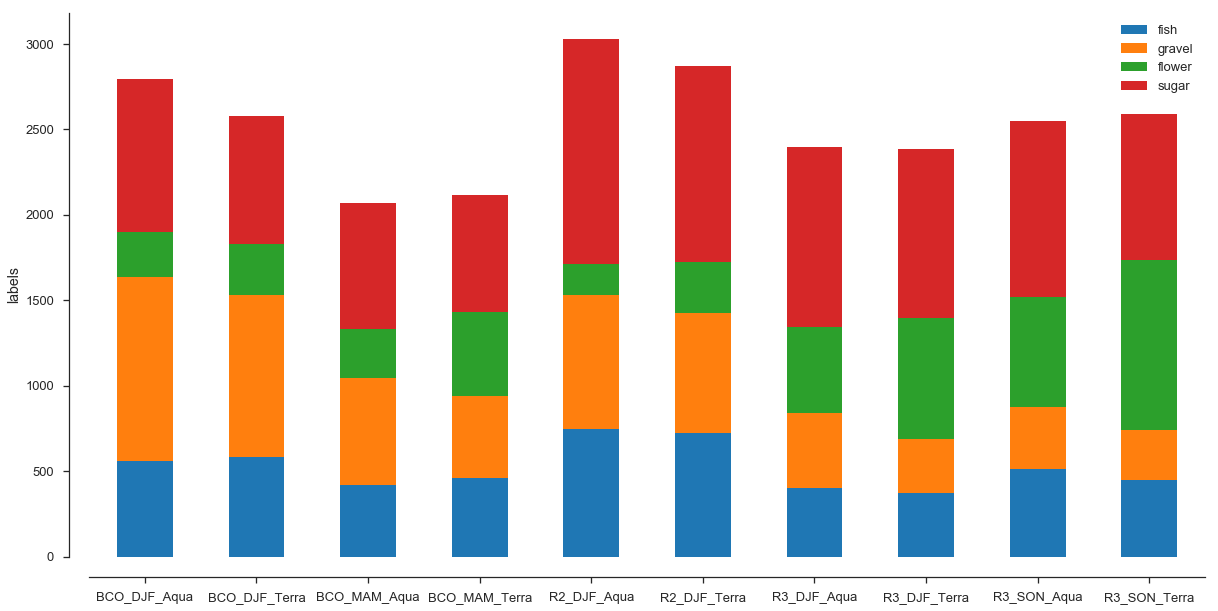

In [23]:
DF=pd.DataFrame.from_dict(region_stat,orient='index')

p=DF.plot(kind='bar',figsize=(20,10),stacked=True)
p.set_ylabel('labels')
sns.despine(offset=20)

The above figure includes both, the practice workflow and the full dataset workflow.

It looks like there is a difference between Aqua and Terra overpasses. Flowers are always less during Aqua than during Terra!

In [24]:
DF['total'] = DF.iloc[:,[0,1,2,3]].sum(axis=1); DF

,fish,gravel,flower,sugar,total
BCO_DJF_Aqua,557,1077,265,897,2796
BCO_DJF_Terra,581,951,295,751,2578
BCO_MAM_Aqua,418,630,284,738,2070
BCO_MAM_Terra,462,481,488,688,2119
R2_DJF_Aqua,745,785,185,1314,3029
R2_DJF_Terra,721,704,298,1148,2871
R3_DJF_Aqua,400,442,502,1054,2398
R3_DJF_Terra,374,315,705,994,2388
R3_SON_Aqua,512,363,645,1030,2550
R3_SON_Terra,450,292,994,854,2590


### Calculating the relative differences between the Aqua and Terra data

In [25]:
DF.loc['BCO_DJF_diff'] = DF.iloc[0,[0,1,2,3]]/DF.iloc[0,4]*100-DF.iloc[1,[0,1,2,3]]/DF.iloc[1,4]*100
DF.loc['BCO_MAM_diff'] = DF.iloc[2,[0,1,2,3]]/DF.iloc[2,4]*100-DF.iloc[3,[0,1,2,3]]/DF.iloc[3,4]*100
DF.loc['R2_DJF_diff'] = DF.iloc[4,[0,1,2,3]]/DF.iloc[4,4]*100-DF.iloc[5,[0,1,2,3]]/DF.iloc[5,4]*100
DF.loc['R3_DJF_diff'] = DF.iloc[6,[0,1,2,3]]/DF.iloc[6,4]*100-DF.iloc[7,[0,1,2,3]]/DF.iloc[7,4]*100
DF.loc['R3_SON_diff'] = DF.iloc[8,[0,1,2,3]]/DF.iloc[8,4]*100-DF.iloc[9,[0,1,2,3]]/DF.iloc[9,4]*100

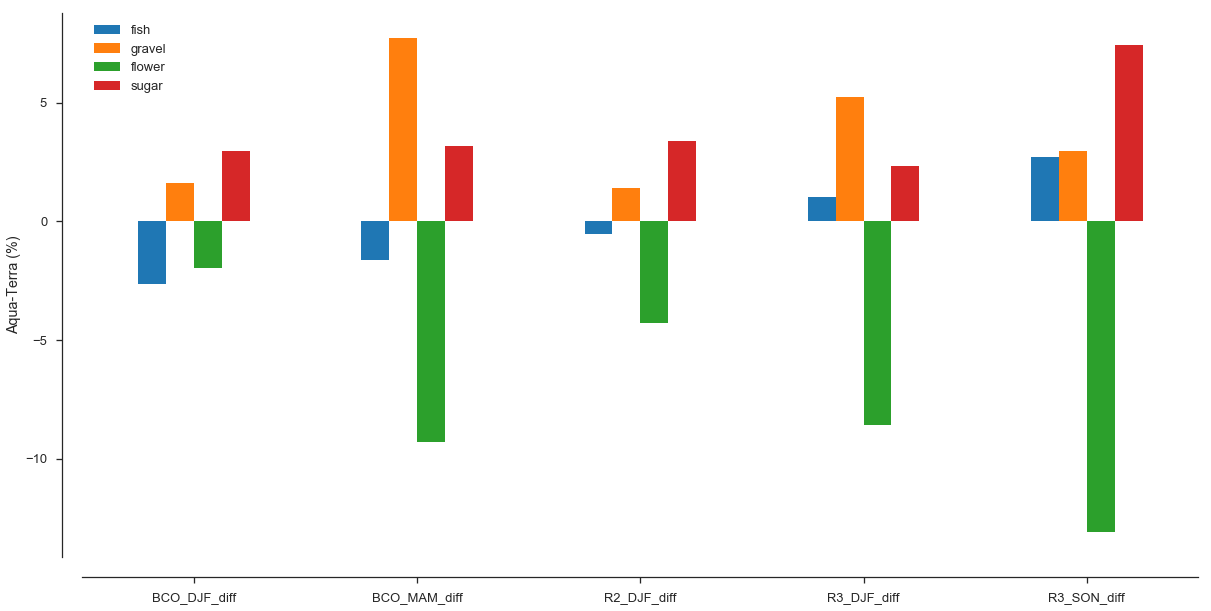

In [26]:
p=DF.loc[['BCO_DJF_diff','BCO_MAM_diff','R2_DJF_diff','R3_DJF_diff','R3_SON_diff'],['fish','gravel','flower','sugar']].plot(kind='bar',figsize=(20,10),stacked=False)
p.set_ylabel('Aqua-Terra (%)')
sns.despine(offset=20)

So the difference between the overpasses is quite obvious. However, the *flower* classifications are always less during Aqua overpasses, but for the region BCO in DJF, where there is no significant change at all.
( Check if that changes when the practice dataset is excluded )

# Practical dataset



In [27]:
image_stat = {}
for e,entry in enumerate(classification_data.iterrows()):
    if entry[1].workflow_id == np.float(8072): #Practical workflow
        nb_fish = nb_gravel = nb_flower = nb_sugar = 0
        subject_id = entry[1].subject_ids
        pattern_types = entry[1].annotations
        labels = [value['tool'] for value in pattern_types['value']]
        [nb_sugar, nb_flower, nb_fish, nb_gravel] = np.bincount(labels,minlength=4)
        try:
            ind = np.where(subject_id == subject_data.index.values)[0][1] #<-- 0: BCO_DJF_Aqua, 1: practice 50 images
            subset_id = subject_data.subject_set_id.values[ind]
            if subset_id == np.float(60902): #check again for savety
                try:
                    image_name = subject_id
                    image_stat = update_dict(image_stat, image_name, {'fish': nb_fish,'gravel': nb_gravel, 'flower': nb_flower, 'sugar':nb_sugar})
                except KeyError:
                    continue
                #image_stat[e] = {'fish': nb_fish,'gravel': nb_gravel, 'flower': nb_flower, 'sugar':nb_sugar}
        except:
            continue

In [28]:
practical_image_DF = pd.DataFrame.from_dict(image_stat); practical_image_DF

,27139637,27139657,27139658,27139668,27139670,27139724,27139807,27139823,27139855,27139862,...,27140640,27140649,27140686,27140720,27140739,27140749,27140760,27140789,27140799,27140829
fish,10,0,0,4,3,13,38,3,54,8,...,2,3,8,28,1,0,7,8,8,2
flower,18,37,0,1,53,28,0,0,3,8,...,20,1,1,0,0,12,45,4,0,0
gravel,23,0,29,25,6,7,38,51,3,4,...,2,6,30,38,43,27,17,25,9,42
sugar,6,4,14,9,9,7,12,12,2,43,...,51,39,6,29,4,12,24,11,57,17


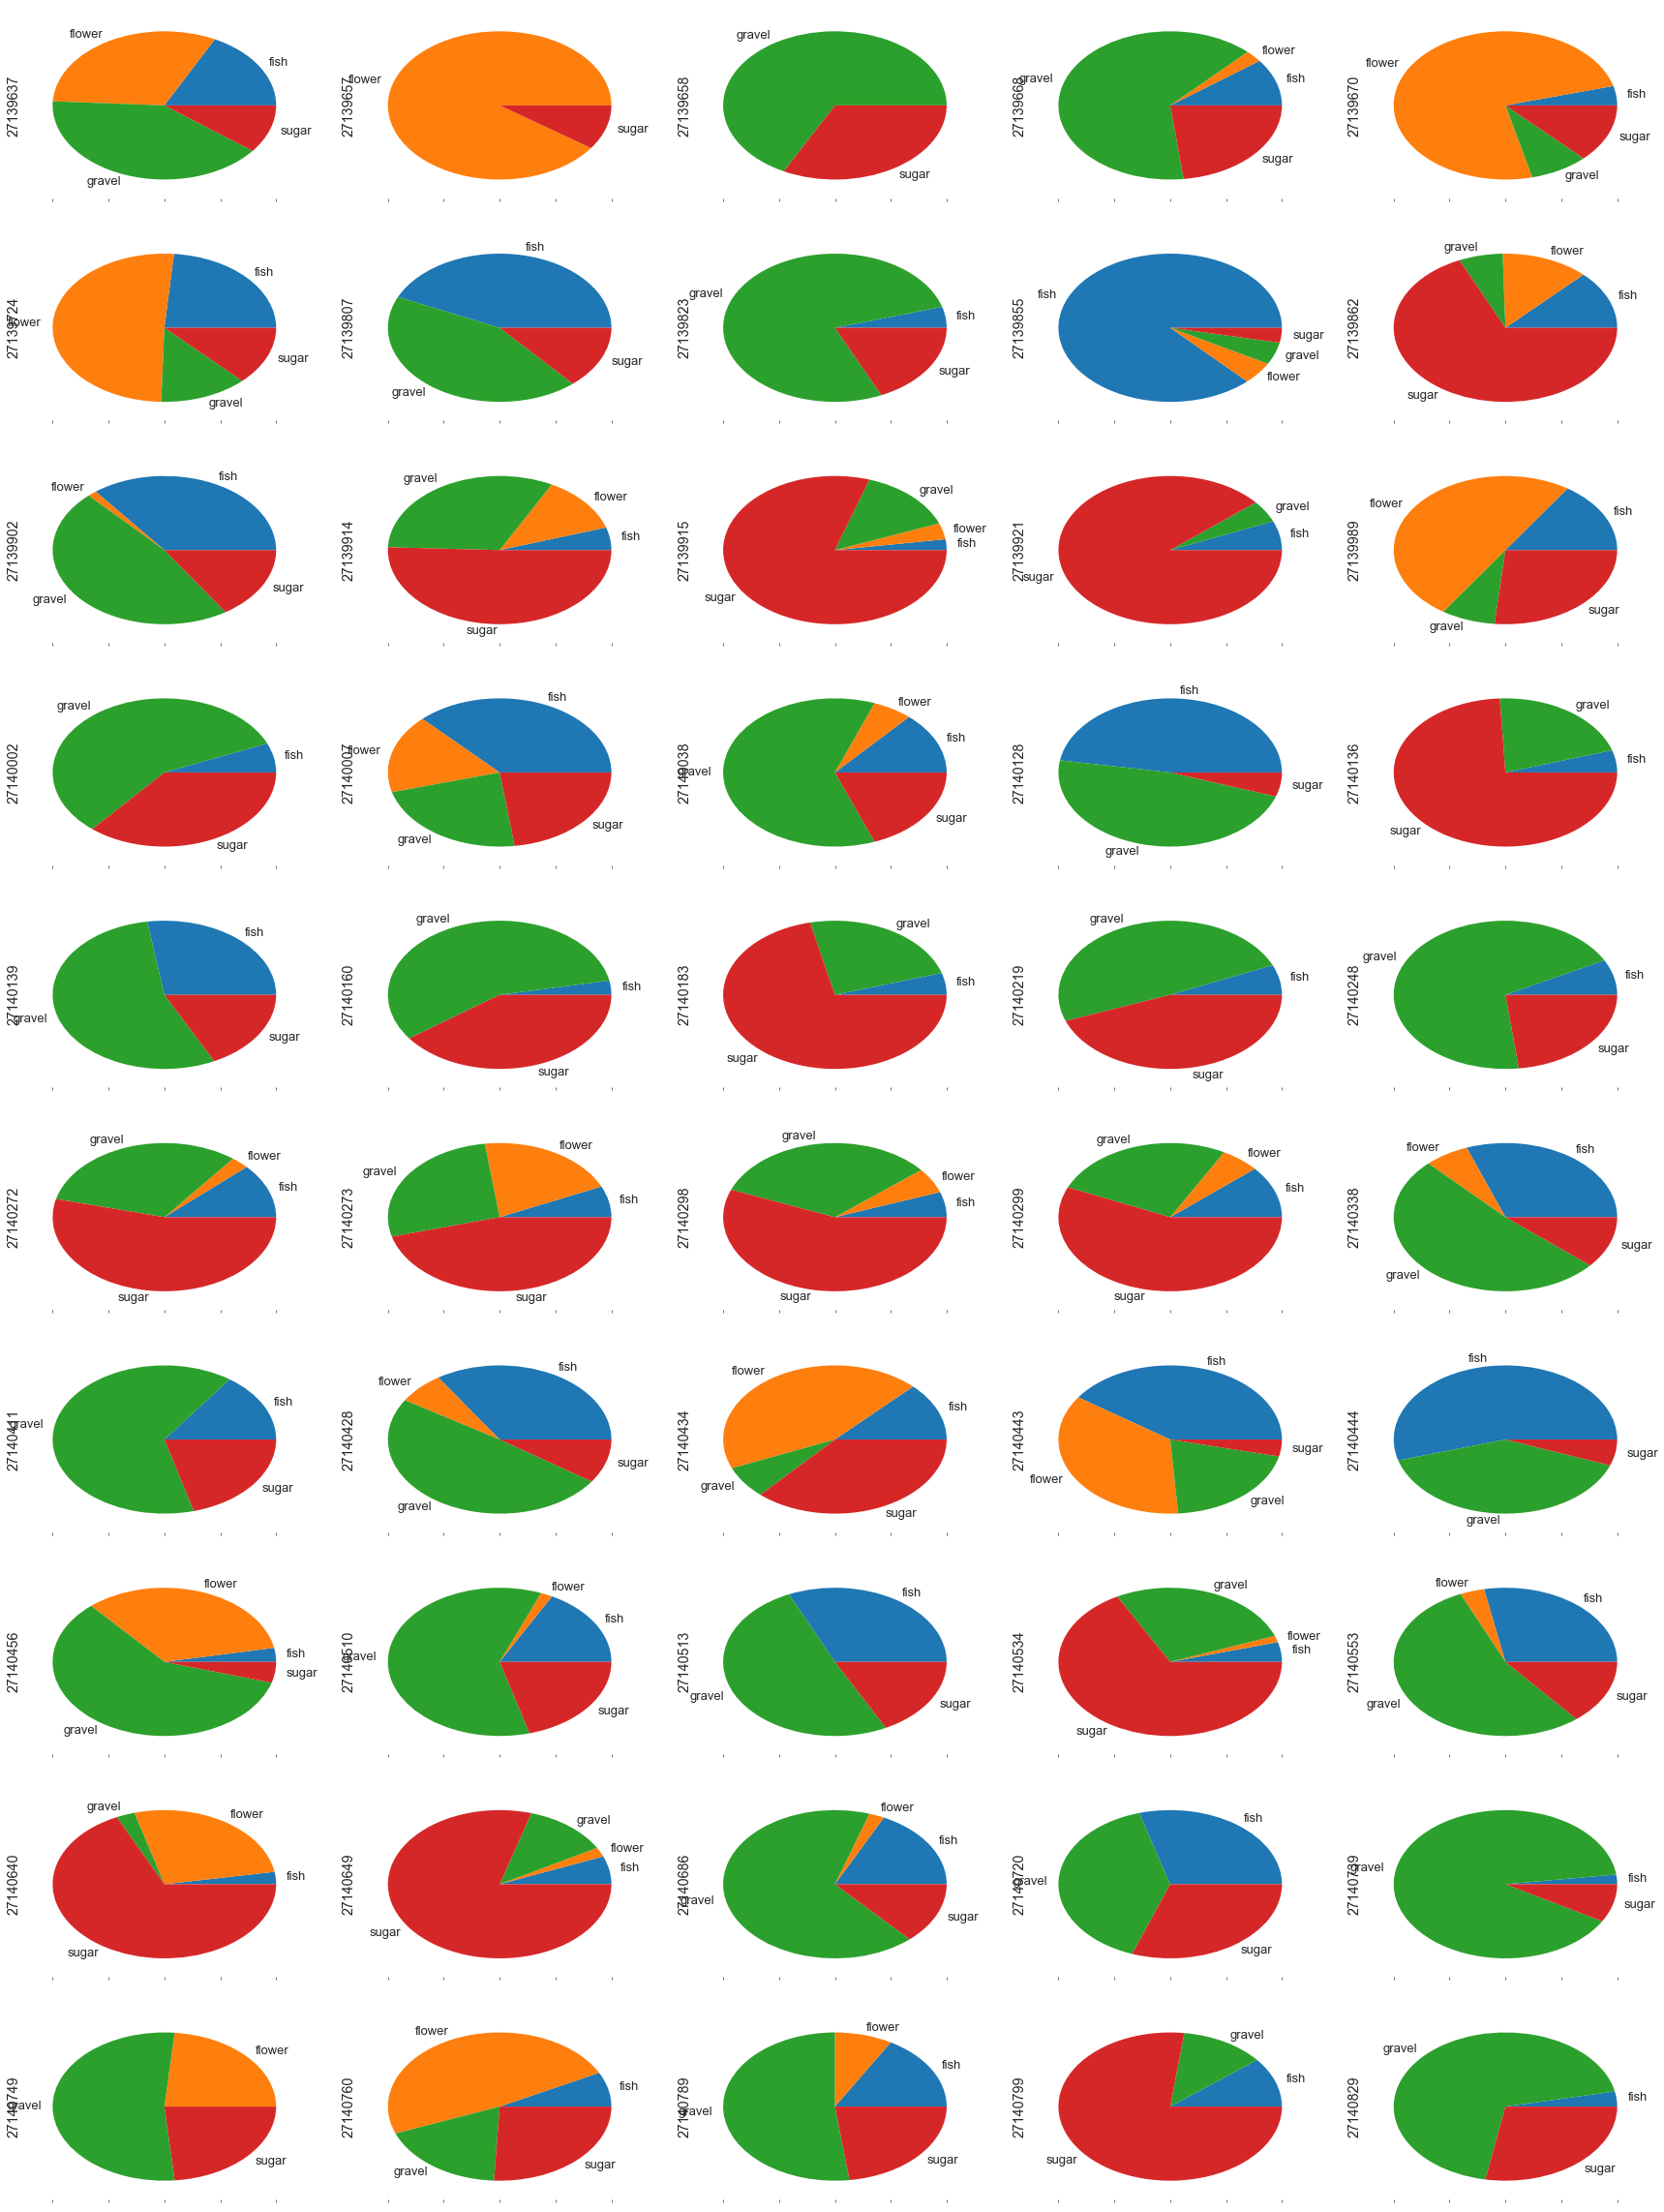

In [29]:
p=practical_image_DF.plot(kind='pie',layout=(12,5), legend=None, subplots=True,figsize=(30,50));